# Price prediction of short-term flat rentals in London

* [Exploratory data analysis](#Exploratory-data-analysis)
* [Interactive plots](#Interactive-plots)
* [Using DBSCAN for cluster similarity search](#Using-DBSCAN-for-cluster-similarity-search)
    * [Fine-tuning silhouette coefficient](#Fine-tuning-silhouette-coefficient)
* [Predictive modeling](#Predictive-modeling)

In [1]:
from pathlib import Path
import itertools
import folium
from folium.plugins import HeatMap
from matplotlib import colormaps
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.cluster import DBSCAN
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

In [2]:
pd.options.display.max_rows = None

In [3]:
home_dir = Path.home()
inside_airbnb_data_dir = home_dir / 'Programming/data/inside-airbnb/london'
inside_airbnb_work_dir = home_dir / 'Programming/Python/machine-learning-exercises/short-term-rents-in-london'

In [4]:
inside_airbnb_data_file = inside_airbnb_data_dir / 'selected_short_term_rentals_with_distances.csv'
inside_airbnb_df = pd.read_csv(inside_airbnb_data_file, keep_default_na=False, thousands=',')

In [5]:
inside_airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   borough              1489 non-null   object 
 1   latitude             1489 non-null   float64
 2   longitude            1489 non-null   float64
 3   property_type        1489 non-null   object 
 4   room_type            1489 non-null   object 
 5   bathrooms            1489 non-null   float64
 6   bedrooms             1489 non-null   float64
 7   price                1489 non-null   float64
 8   minimum_nights       1489 non-null   int64  
 9   crime_rate           1489 non-null   float64
 10  amenities            1489 non-null   object 
 11  nearest_station      1489 non-null   object 
 12  distance_to_station  1489 non-null   float64
dtypes: float64(7), int64(1), object(5)
memory usage: 151.4+ KB


In [6]:
inside_airbnb_df.drop(['room_type', 'nearest_station'], axis=1, inplace=True)
inside_airbnb_df['borough'].replace({r'\s': r'_'}, regex=True, inplace=True)

/var/folders/0g/qngbcycj71l5m10mjn_2bxxh0000gn/T/ipykernel_24790/3101622711.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inside_airbnb_df['borough'].replace({r'\s': r'_'}, regex=True, inplace=True)


In [7]:
inside_airbnb_df.head()

,borough,latitude,longitude,property_type,bathrooms,bedrooms,price,minimum_nights,crime_rate,amenities,distance_to_station
0,Lambeth,51.491476,-0.111514,Entire rental unit,1.0,1.0,150.0,30,137.98,None,0.520193
1,Kensington_and_Chelsea,51.485660,-0.184150,Entire rental unit,2.0,2.0,195.0,91,118.02,"Nightlife, Restaurant",0.956708
2,Brent,51.538990,-0.197440,Entire rental unit,1.5,2.0,83.0,30,117.59,Grocery Store,0.481797
3,Kensington_and_Chelsea,51.517320,-0.200500,Entire rental unit,1.0,2.0,288.0,91,118.02,Restaurant,0.398479
4,Westminster,51.496950,-0.138880,Entire rental unit,3.0,4.0,901.0,186,132.94,"Restaurant, Retail",0.200253


In [8]:
inside_airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   borough              1489 non-null   object 
 1   latitude             1489 non-null   float64
 2   longitude            1489 non-null   float64
 3   property_type        1489 non-null   object 
 4   bathrooms            1489 non-null   float64
 5   bedrooms             1489 non-null   float64
 6   price                1489 non-null   float64
 7   minimum_nights       1489 non-null   int64  
 8   crime_rate           1489 non-null   float64
 9   amenities            1489 non-null   object 
 10  distance_to_station  1489 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 128.1+ KB


## Exploratory data analysis

In [9]:
inside_airbnb_df.borough.unique()

array(['Lambeth', 'Kensington_and_Chelsea', 'Brent', 'Westminster',
       'Hammersmith_and_Fulham', 'Islington', 'Hackney', 'Camden',
       'Wandsworth', 'Southwark', 'Haringey', 'Hounslow', 'Tower_Hamlets',
       'Barnet', 'Richmond_upon_Thames', 'Enfield', 'Newham', 'Sutton',
       'Kingston_upon_Thames', 'Lewisham', 'Harrow', 'Croydon',
       'Greenwich', 'Merton', 'Ealing', 'Bromley', 'City_of_London',
       'Waltham_Forest', 'Hillingdon', 'Bexley', 'Havering', 'Redbridge',
       'Barking_and_Dagenham'], dtype=object)

In [10]:
borough_sr = inside_airbnb_df.borough.value_counts()

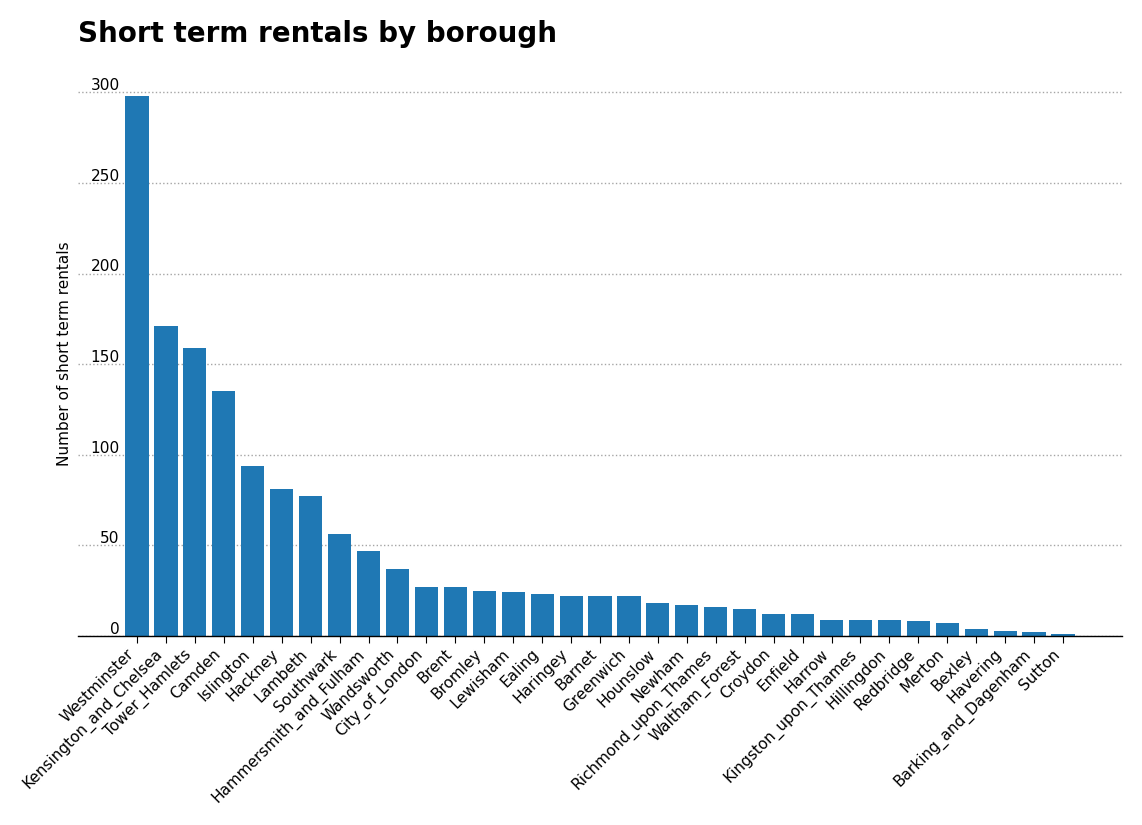

In [11]:
mplstyle_file = inside_airbnb_work_dir / 'barplot-style.mplstyle'
plt.style.use(mplstyle_file)
fig, ax = plt.subplots( nrows=1, ncols=1)
ax.bar(borough_sr.index, borough_sr.values)
ax.set_ylabel('Number of short term rentals')
ax.set_title('Short term rentals by borough')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
path_plots = inside_airbnb_work_dir / 'plots'
path_plots.mkdir(exist_ok=True, parents=True)
plot_filename = path_plots / 'short-term-rentals.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

In [12]:
prices_data = inside_airbnb_df.price.values
prices_data = prices_data.astype('float')

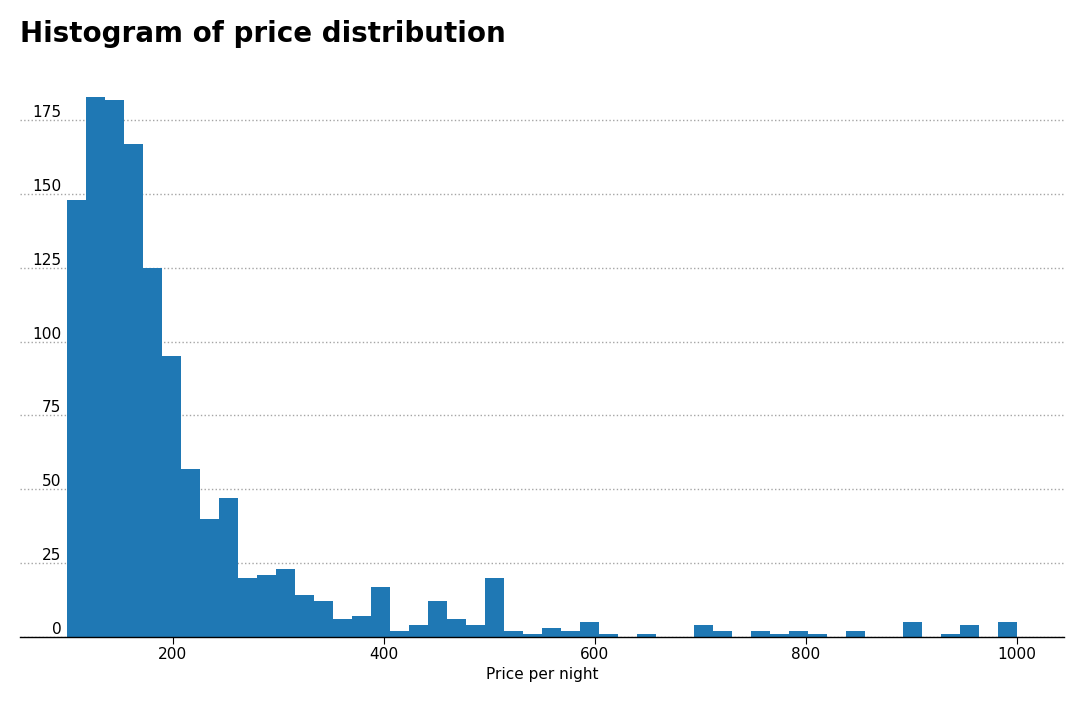

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(prices_data, bins=50, range=[100, 1000])
ax.set_title('Histogram of price distribution')
ax.set_xlabel('Price per night')
plot_filename = path_plots / 'hist_price_distrib.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

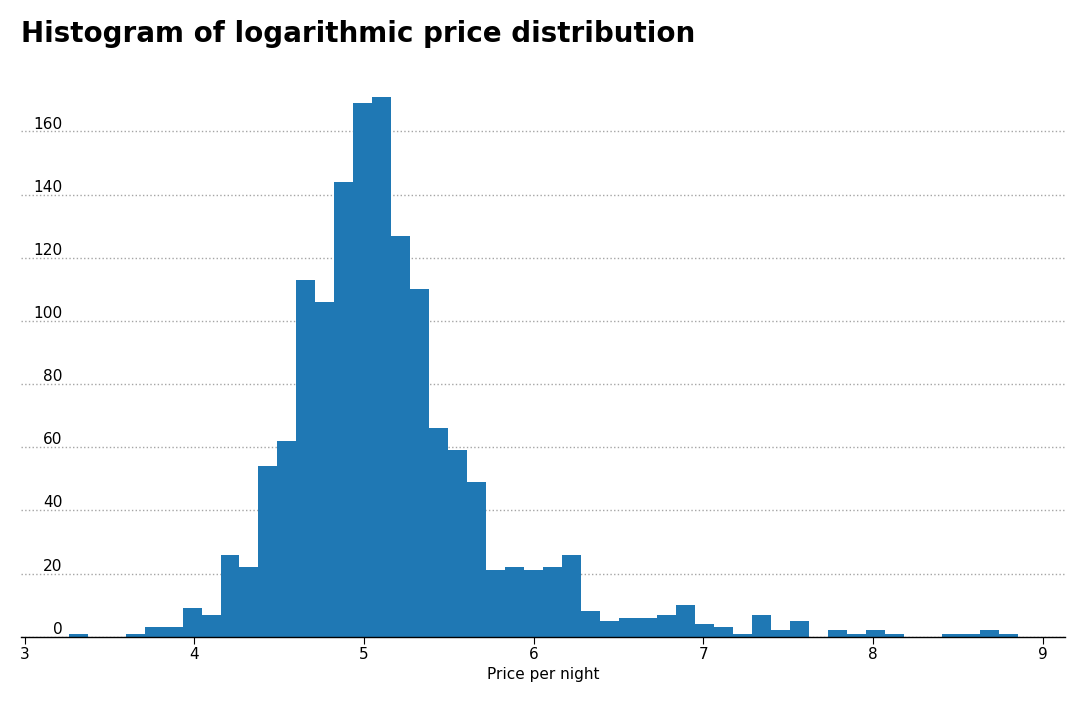

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(np.log1p(prices_data), bins=50)
ax.set_title('Histogram of logarithmic price distribution')
ax.set_xlabel('Price per night')
plot_filename = path_plots / 'hist_log_price_distrib.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

In [15]:
min_nights_data = inside_airbnb_df.minimum_nights.values
min_nights_data = min_nights_data.astype('int')

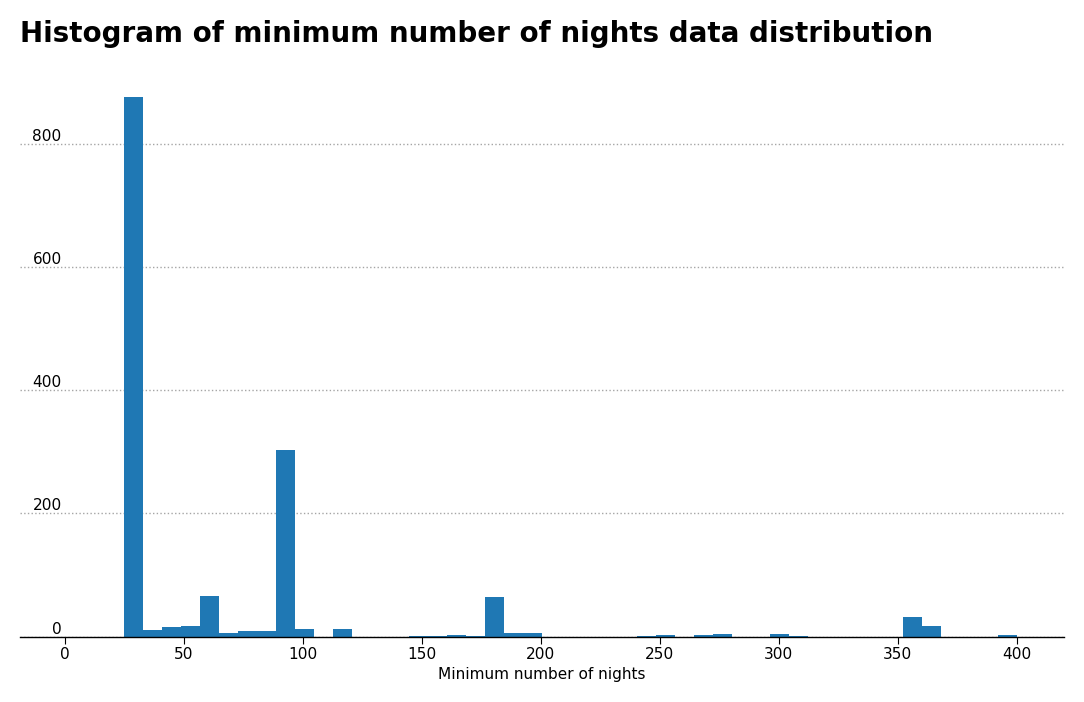

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.hist(min_nights_data, bins=50, range=[1, 400])
ax.set_title('Histogram of minimum number of nights data distribution')
ax.set_xlabel('Minimum number of nights')
plot_filename = path_plots / 'min_nights_data_distrib.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

In [17]:
property_type_sr = inside_airbnb_df.property_type.value_counts()

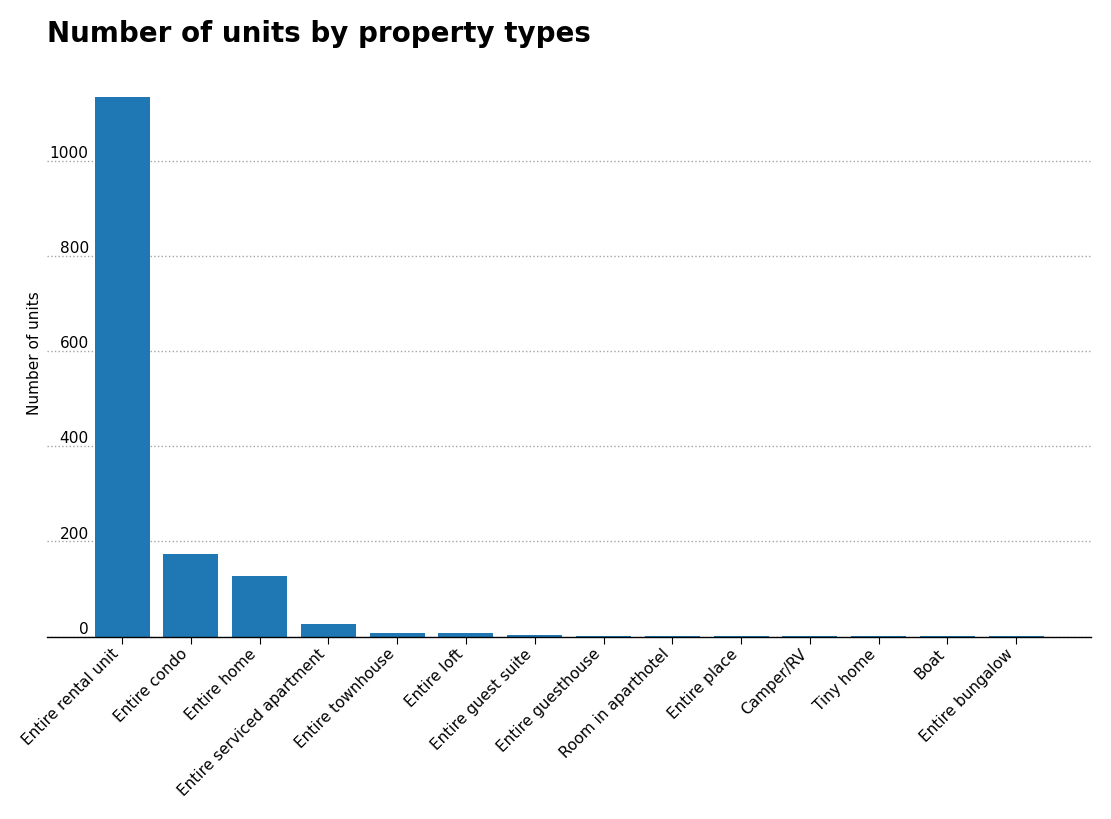

In [18]:
fig, ax = plt.subplots( nrows=1, ncols=1)
ax.bar(x=property_type_sr.index, height=property_type_sr.values)
ax.set_ylabel('Number of units')
ax.set_title('Number of units by property types')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plot_filename = path_plots / 'num_units_property.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

In [19]:
average_price_per_borough_sr = inside_airbnb_df.price.groupby(inside_airbnb_df.borough).mean()
average_price_per_borough_sr.sort_values(ascending=False, inplace=True)

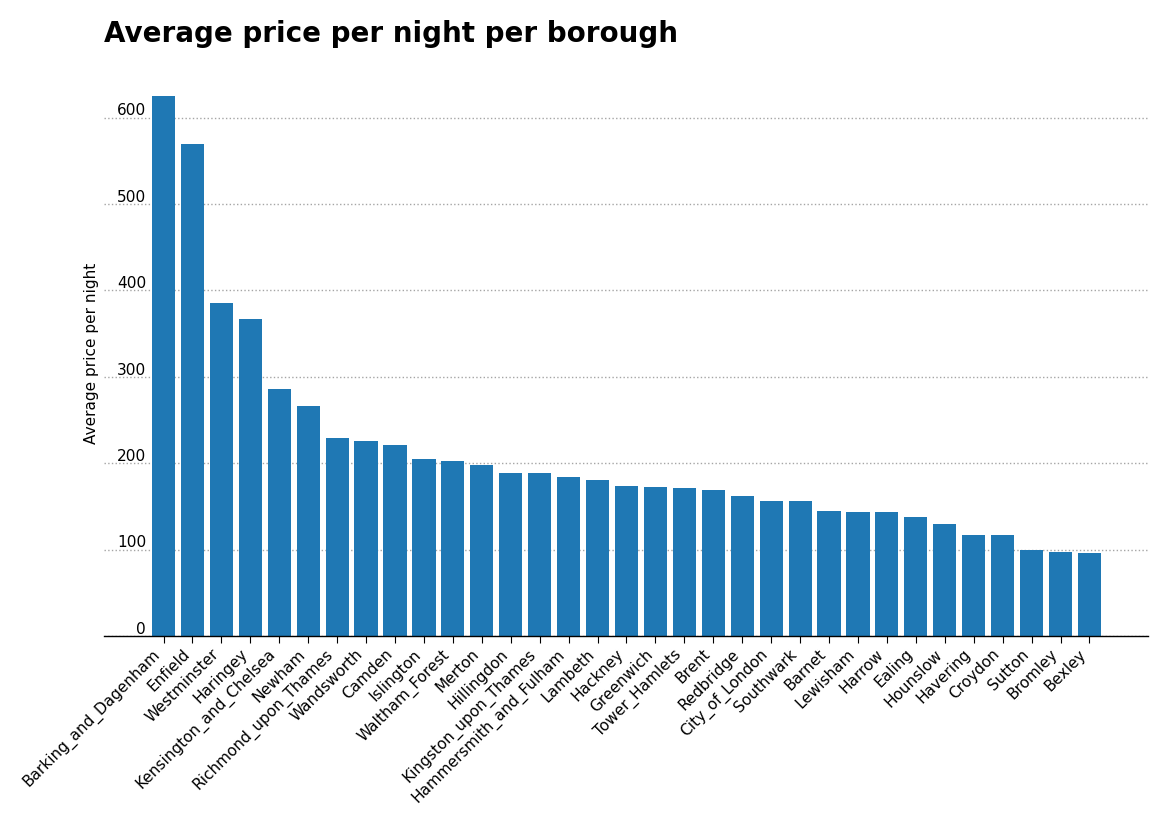

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.bar(average_price_per_borough_sr.index, average_price_per_borough_sr.values)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Average price per night')
ax.set_title('Average price per night per borough')
plot_filename = path_plots / 'average_price_borough.png'
if not plot_filename.exists():
    plt.savefig(plot_filename, dpi=144, bbox_inches='tight');

## Interactive plots

In [21]:
london_map_1 = folium.Map(location=[51.5074, -0.1278], zoom_start=12, tiles='CartoDB Voyager')

In [22]:
borough_names = inside_airbnb_df['borough'].unique()
num_locations = len(borough_names)
colormap = list(itertools.chain(
    colormaps['tab20b'].colors,
    colormaps['tab20c'].colors
))
location_colors = {loc: colors.rgb2hex(colormap[i]) for i, loc in enumerate(borough_names)}

In [23]:
for _, row in inside_airbnb_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color=location_colors[row['borough']],
        fill=True,
        fill_color=location_colors[row['borough']],
        fill_opacity=0.6,
        weight=0,
    ).add_to(london_map_1)

In [24]:
path_plots = inside_airbnb_work_dir / 'html'
path_plots.mkdir(exist_ok=True, parents=True)
density_map_file = inside_airbnb_work_dir / 'html/density_map.html'
if not density_map_file.exists():
    london_map_1.save(density_map_file)
london_map_1

In [25]:
london_map_2 = folium.Map(location=[51.5074, -0.1278], zoom_start=12, tiles='CartoDB Voyager')

In [26]:
_ = HeatMap(
        inside_airbnb_df[['latitude', 'longitude']].values,
        radius=20,
        blur=10,
        min_opacity=0.2,
        max_opacity=0.8,
).add_to(london_map_2)

In [27]:
heat_map_file = inside_airbnb_data_dir / 'html/heat_map.html'
if not heat_map_file.exists():
    london_map_2.save(inside_airbnb_work_dir / 'html/heat_map.html')
london_map_2

### Using DBSCAN for cluster similarity search

In [28]:
coordinates = inside_airbnb_df[['latitude', 'longitude']]
db = DBSCAN(eps=0.03, min_samples=10, metric='haversine').fit(coordinates)
labels = db.labels_

In [29]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [30]:
print("Estimated number of clusters: {:d}".format(n_clusters_))
print("Estimated number of noise points: {:d}".format(n_noise_))

Estimated number of clusters: 2
Estimated number of noise points: 7


In [31]:
print(f"Silhouette Coefficient: {metrics.silhouette_score(coordinates, labels):.3f}")

Silhouette Coefficient: 0.584


In [32]:
def calculate_cluster_center(cluster_label):
    coords = coordinates[labels == cluster_label]
    cluster_center = coords.mean(axis=0)
    print(f"Cluster center {cluster_label} (latitude: {cluster_center.iloc[0]:.5f}, longitude: {cluster_center.iloc[1]:.5f})")
    return cluster_center

In [33]:
for index in list(np.unique(labels)):
    _ = calculate_cluster_center(index)

Cluster center -1 (latitude: 51.49828, longitude: -0.27112)
Cluster center 0 (latitude: 51.51262, longitude: -0.13268)
Cluster center 1 (latitude: 51.37574, longitude: 0.09905)


In [34]:
def plot_clusters(coordinates, eps=0.03, min_samples=10):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine').fit(coordinates)
    cluster_labels = db.labels_
    unique_cluster_labels = np.unique(cluster_labels)
    print(f'Unique cluster labels: {unique_cluster_labels}')

    # Create GeoDataFrame of points with labels
    geometry = [Point(lon, lat) for lat, lon in coordinates.values]
    gdf_points = gpd.GeoDataFrame({'label': cluster_labels}, geometry=geometry, crs="EPSG:4326")
    # Project all to Web Mercator
    gdf_points = gdf_points.to_crs(epsg=3857)

    cluster_center_dict = {}
    for c_label in unique_cluster_labels:
        cluster_coords = coordinates[cluster_labels == c_label]
        cluster_center = cluster_coords.mean(axis=0)
        gdf_center = gpd.GeoDataFrame(geometry=[Point(cluster_center.iloc[1], cluster_center.iloc[0])], crs="EPSG:4326")
        # Project all to Web Mercator
        gdf_center = gdf_center.to_crs(epsg=3857)
        cluster_center_dict[c_label] = gdf_center

    # Load London boroughs
    boroughs_path = inside_airbnb_data_dir / 'neighbourhoods.geojson'
    gdf_boroughs = gpd.read_file(boroughs_path).to_crs(epsg=3857)

    # Plotting
    fig, ax = plt.subplots()

    # Plot boroughs
    gdf_boroughs.boundary.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.6)

    colormap = colormaps['Set1'].colors
    cluster_colors = {label: colors.rgb2hex(colormap[i]) for i, label in enumerate(unique_cluster_labels)}

    # Plot property points with cluster colors
    for c_label in unique_cluster_labels:
        subset = gdf_points[gdf_points['label'] == c_label]
        # color = 'blue' if label == 0 else 'green' if label != -1 else 'lightgray'
        color = cluster_colors[c_label]
        marker = 'o' if c_label != -1 else 'x'
        subset.plot(ax=ax, color=color, markersize=30, marker=marker, alpha=0.8, label=f'Cluster {c_label}')
        # Plot cluster center
        gdf_center = cluster_center_dict[c_label]
        gdf_center.plot(ax=ax, color='red', marker='*', markersize=100, label='Cluster center')
        
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Final touches
    ax.set_title("DBSCAN clustered properties with boroughs in London", fontsize=15)
    ax.legend()
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

Unique cluster labels: [-1  0  1]


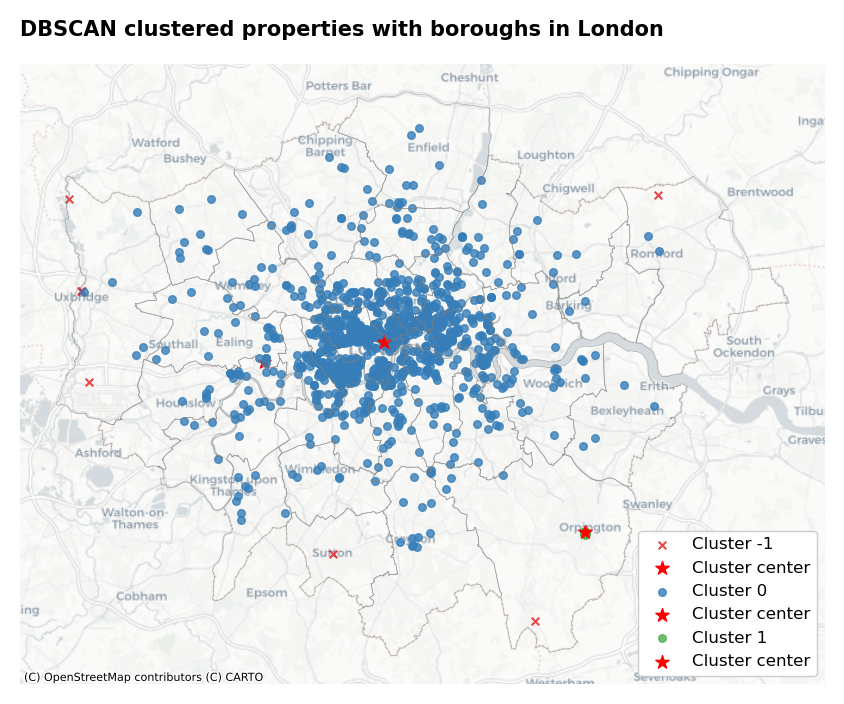

In [35]:
plot_clusters(coordinates, eps=0.03, min_samples=10)

#### Fine-tuning silhouette coefficient

In [36]:
sil_score_dict = {}
sil_score_range = np.linspace(0.01, 0.1, 10)
min_samples=100
for eps_param in sil_score_range:
    db = DBSCAN(eps=eps_param, min_samples=min_samples, metric='haversine').fit(coordinates)
    labels = db.labels_
    if len(set(labels)) >= 2:
        sil_score = metrics.silhouette_score(coordinates, labels)
        sil_score_dict[eps_param] = sil_score
    else:
        print(f'Silhouette score cannot be computed: only 1 cluster found for eps={eps_param.round(2)}')

Silhouette score cannot be computed: only 1 cluster found for eps=0.1


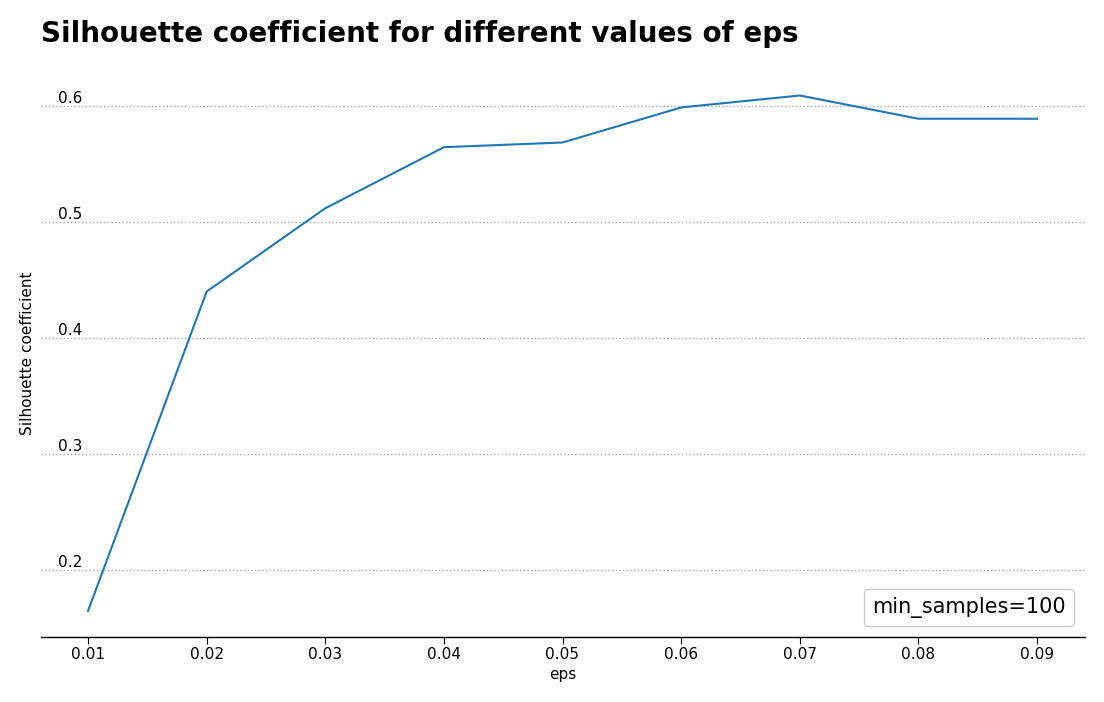

In [37]:
fig, ax = plt.subplots()
ax.plot(sil_score_dict.keys(), sil_score_dict.values(), label='min_samples={}'.format(min_samples))
ax.legend(loc=4, handlelength=0, handletextpad=0, prop={'size': 15})
ax.set_xlabel("eps")
ax.set_ylabel("Silhouette coefficient")
ax.set_title("Silhouette coefficient for different values of eps");

In [38]:
sil_score_dict = {}
min_sample_range = np.linspace(50, 200, 10)
eps=0.07
for min_sample in min_sample_range:
    db = DBSCAN(eps=eps, min_samples=int(min_sample), metric='haversine').fit(coordinates)
    labels = db.labels_
    if len(set(labels)) >= 2:
        sil_score = metrics.silhouette_score(coordinates, labels)
        sil_score_dict[min_sample] = sil_score
    else:
        print(f'Silhouette score cannot be computed: only 1 cluster found for eps={min_sample}')

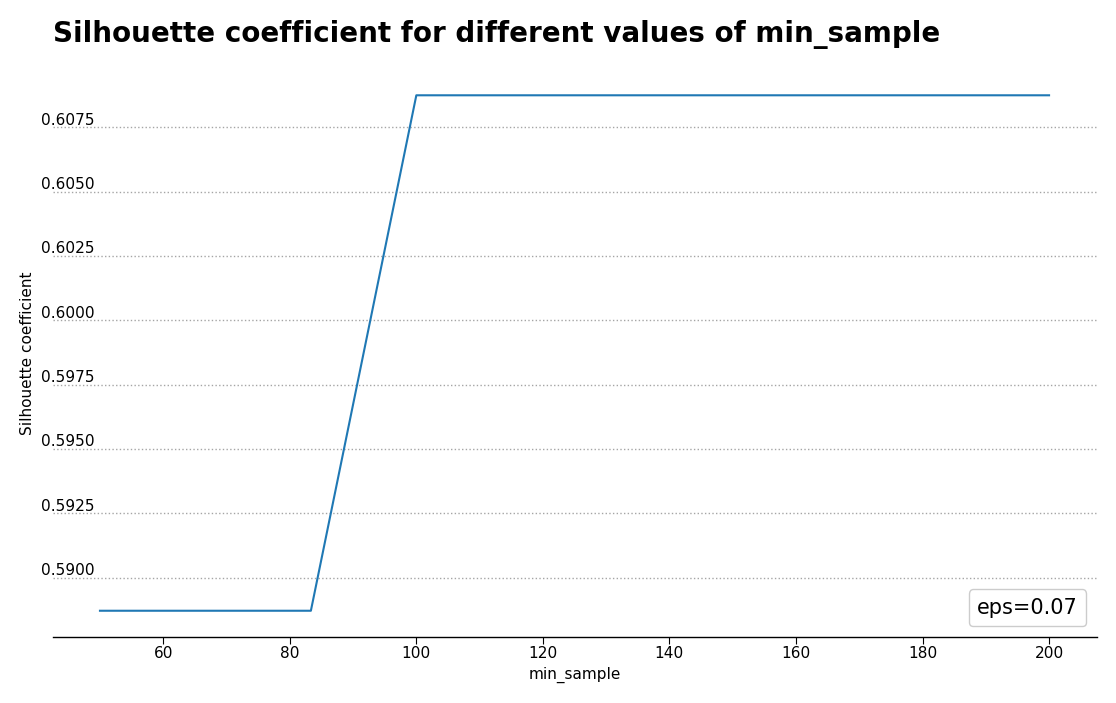

In [39]:
fig, ax = plt.subplots()
ax.plot(sil_score_dict.keys(), sil_score_dict.values(), label='eps={}'.format(eps))
ax.legend(loc=4, handlelength=0, handletextpad=0, prop={'size': 15})
ax.set_xlabel("min_sample")
ax.set_ylabel("Silhouette coefficient")
ax.set_title("Silhouette coefficient for different values of min_sample");

Using `eps=0.05` and `min_sample=100`:

In [40]:
coordinates = inside_airbnb_df[['latitude', 'longitude']]
db = DBSCAN(eps=0.05, min_samples=100, metric='haversine').fit(coordinates)
labels = db.labels_

In [41]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [42]:
print("Estimated number of clusters: {:d}".format(n_clusters_))
print("Estimated number of noise points: {:d}".format(n_noise_))

Estimated number of clusters: 1
Estimated number of noise points: 36


In [43]:
print(f"Silhouette Coefficient: {metrics.silhouette_score(coordinates, labels):.3f}")

Silhouette Coefficient: 0.568


In [44]:
cluster_points = coordinates[labels == 0]
cluster_center = cluster_points.mean(axis=0)
print(f"Cluster center (latitude: {cluster_center.iloc[0]:.5f}, longitude: {cluster_center.iloc[1]:.5f})")

Cluster center (latitude: 51.51361, longitude: -0.13286)


## Predictive modeling

In [45]:
inside_airbnb_df = inside_airbnb_df.loc[inside_airbnb_df['borough'] != 'Sutton']

In [46]:
inside_airbnb_df[['amenity_1', 'amenity_2', 'amenity_3']] = inside_airbnb_df['amenities'].str.split(',', expand=True)
inside_airbnb_df = inside_airbnb_df.drop('amenities', axis=1)

In [47]:
df_full_train, df_test = train_test_split(inside_airbnb_df, test_size=0.2, random_state=33, stratify=inside_airbnb_df['borough'])
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=33, stratify=df_full_train['borough'])

In [48]:
df_train.shape, df_val.shape, df_test.shape

((892, 13), (298, 13), (298, 13))

In [49]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [50]:
X_train = df_train.drop('price', axis=1)
X_val = df_val.drop('price', axis=1)
X_test = df_test.drop('price', axis=1)

In [51]:
y_train = df_train['price'].copy()
y_val = df_val['price'].copy()
y_test = df_test['price'].copy()

In [52]:
X_train.tail()

,borough,latitude,longitude,property_type,bathrooms,bedrooms,minimum_nights,crime_rate,distance_to_station,amenity_1,amenity_2,amenity_3
887,Tower_Hamlets,51.515904,-0.072097,Entire rental unit,1.0,1.0,30,98.60,0.067244,Restaurant,Retail,None
888,Tower_Hamlets,51.498180,-0.019190,Entire condo,1.0,1.0,30,98.60,0.586336,Grocery Store,Restaurant,None
889,Westminster,51.532990,-0.168020,Entire condo,1.0,1.0,30,132.94,0.445213,Restaurant,None,None
890,Tower_Hamlets,51.501760,-0.022670,Entire rental unit,1.0,1.0,45,98.60,0.269656,Restaurant,None,None
891,Camden,51.530007,-0.118149,Entire rental unit,1.0,1.0,30,108.07,0.274649,Cafe,None,None


In [53]:
cat_columns = ['borough', 'amenity_1', 'amenity_2', 'amenity_3']
cat_encoder = OneHotEncoder()
rental_cat = X_train[cat_columns]
rental_cat_1hot = cat_encoder.fit_transform(rental_cat)

In [54]:
cat_encoder.get_feature_names_out()

array(['borough_Barking_and_Dagenham', 'borough_Barnet', 'borough_Bexley',
       'borough_Brent', 'borough_Bromley', 'borough_Camden',
       'borough_City_of_London', 'borough_Croydon', 'borough_Ealing',
       'borough_Enfield', 'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith_and_Fulham', 'borough_Haringey',
       'borough_Harrow', 'borough_Havering', 'borough_Hillingdon',
       'borough_Hounslow', 'borough_Islington',
       'borough_Kensington_and_Chelsea', 'borough_Kingston_upon_Thames',
       'borough_Lambeth', 'borough_Lewisham', 'borough_Merton',
       'borough_Newham', 'borough_Redbridge',
       'borough_Richmond_upon_Thames', 'borough_Southwark',
       'borough_Tower_Hamlets', 'borough_Waltham_Forest',
       'borough_Wandsworth', 'borough_Westminster', 'amenity_1_Cafe',
       'amenity_1_Cultural', 'amenity_1_Education',
       'amenity_1_Entertainment', 'amenity_1_Fitness',
       'amenity_1_Grocery Store', 'amenity_1_Healthcare',
       'amenity_

In [55]:
# lm = LinearRegression()
# lm.fit(X_train, y_train)